# Fundamental Matrix and RANSAC

In this exercise, you will learn:
- how to estimate the fundamental matrix $F$ that geometrically relates two views of the same scene
- how to make your estimation more robust to outliers and noise which is important in practice

For some functions we already provide some draft implementation that you just need to complete. This is supposed to help you identifying the next steps. Still, if it does not fit your idea you may ignore it.

## 1. Setup

Load all libraries and both views that we will work with. In this exercise you are given two views again and matching key points which we extracted in advance.

In [ ]:
import numpy as np
from numba import jit, njit
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal

In [ ]:
from matplotlib.patches import ConnectionPatch

# use this function to visualize the matches
def plot_matches(img1, img2, keypoints1, keypoints2):
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    
    # draw matches
    for kp1, kp2 in zip(keypoints1, keypoints2):
        c = np.random.rand(3)
        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color=c)
        fig.add_artist(con)
        axes[0].plot(*kp1, color=c, marker='x')
        axes[1].plot(*kp2, color=c, marker='x')
    
    plt.show()

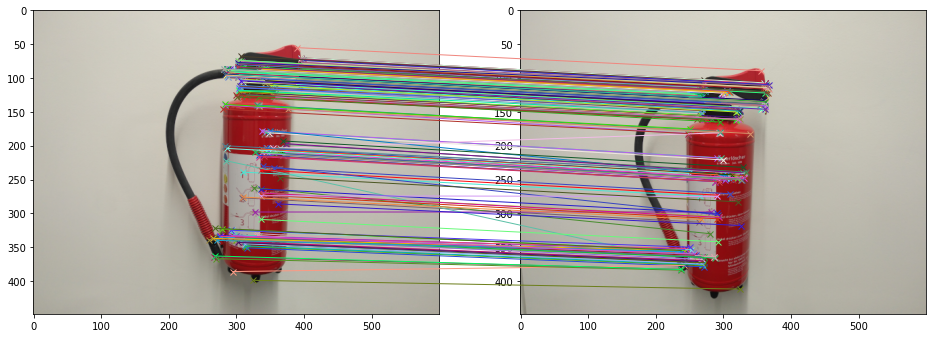

In [ ]:
# Load images
view1 = np.array(Image.open("data/exercise3/view1.png")) / 255
view2 = np.array(Image.open("data/exercise3/view2.png")) / 255

# Load matching keypoints
with np.load("data/exercise4/keypoints.npz") as data:
    keypoints1 = data["view1"]
    keypoints2 = data["view2"]
    
plot_matches(view1, view2, keypoints1, keypoints2)

### 4.1. Fundamental Matrix
We begin with computing the fundamental matrix $F$ which defines the epipolar constraints for two views of two uncalibrated cameras. It determines the lines corresponding points can lie on. If we have a total of eight pairs of corresponding points this matrix can be estimated using the 8-point algorithm discussed in the lecture, see slide deck 

Your task now is to use eight point matches and compute the fundamental matrix $F$ by performing a direct linear transform and then decompose the resulting matrix using SVD. You might want to look at the slides again.

Hint: Use `numpy.linalg.svd` for singular value decomposition and do not forget to rescale the point coordinates to obtain stable results (this is termed 'conditioning' on the slides).

In [ ]:
# Max version
@jit
def find_fundamental_svd(kps1, kps2):
    """
    Estimate fundamental matrix using SVD 
    :param kps1: keypoints extracted from view1 in homogeneous coordinates
    :param kps2: keypoints extracted from view2 in homogeneous coordinates
    """
    assert kps1.shape == kps2.shape
    
    if kps1.shape[1] == 2:
        kps1 = np.hstack((kps1, np.ones((kps1.shape[0],1))))
        kps2 = np.hstack((kps2, np.ones((kps2.shape[0],1))))
    
    # condition points
    s1 = np.max(np.linalg.norm(kps1, 2, axis=1))
    s2 = np.max(np.linalg.norm(kps2, 2, axis=1))
    t1 = np.mean(kps1, axis=0)
    t2 = np.mean(kps2, axis=0)
    
    
    T1 = np.array([[1/s1, 0, -t1[0]/s1],
                   [0, 1/s1, -t1[1]/s1],
                   [0,    0,         1]])
    
    T2 = np.array([[1/s2, 0, -t2[0]/s2],
                   [0, 1/s2, -t2[1]/s2],
                   [0,    0,         1]])
    
    kps1n = np.array([np.dot(T1, kps1[i]) for i in range(kps1.shape[0])])
    kps2n = np.array([np.dot(T2, kps2[i]) for i in range(kps2.shape[0])])
    
    # collect equations
    x1 = kps1n[:,0]
    x2 = kps2n[:,0]
    y1 = kps1n[:,1]
    y2 = kps2n[:,1]
    
    A = np.array([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, np.ones(kps1.shape[0])]).T

    # solve for fundamental matrix using SVD
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    
    ### Solution ist the last row of vh
    f = vh[-1]
    F = np.reshape(f, (3,3))
    
    # uncondition F
    F = T1.T @ F @ T2
    
    # make rank 2
    u, s, vh = np.linalg.svd(F, full_matrices=True)
    s[2] = 0
    F = u @ np.diag(s) @ vh
     
    return F

In [77]:
# compute F from a set of 8 point matches

keypoints1 = np.hstack((keypoints1, np.ones((keypoints1.shape[0],1))))
keypoints2 = np.hstack((keypoints2, np.ones((keypoints2.shape[0],1))))
F = find_fundamental_svd(keypoints1[:8], keypoints2[:8])

/tmp/ipykernel_18087/2472699275.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "find_fundamental_svd" failed type inference due to: No implementation of function Function(<function norm at 0x7f32b00f0510>) found for signature:
 
 >>> norm(array(float64, 2d, C), Literal[int](2), axis=Literal[int](1))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2351.
        With argument(s): '(array(float64, 2d, C), int64, axis=int64)':
       Rejected as the implementation raised a specific error:
         TypeError: norm_impl() got an unexpected keyword argument 'axis'
  raised from /home/nase/Documents/Uni/Heidelberg/Sem3/ComputerVision/3dcv-students/lib/python3.7/site-packages/numba/core/typing/templates.py:775

During: resolving callee type: Function(<function norm at 0x7f32b00f0510>)
During: typing of call at /tmp/ipykernel_18087/24

Check your code by visualizing the epipolar lines of you key points. We provide the function for this below. What do you see?

In [78]:
def visualize_epipolar_lines(img1, img2, keypoints1, keypoints2, F):
    """
    :params img1: view 1
    :params img2: view 2
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :params F: the fundamental matrix
    """
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    res = img1.shape[:2]
    
    for color_index, (kp1, kp2) in enumerate(zip(keypoints1, keypoints2)):
        c = np.random.rand(3)
        
        # plot points
        axes[0].plot(kp1[0], kp1[1], color=c, marker='o',markersize=5)
        axes[1].plot(kp2[0], kp2[1], color=c, marker='o',markersize=5)
        
        # compute epi lines
        epi_line_2 = kp1[None,...] @ F
        epi_line_1 = F @ kp2[None,...].T
        
        # plot lines
        for i, line in enumerate([epi_line_1, epi_line_2]):
            line = line.flatten()
            fn = lambda x: (line[0]*x + line[2]) / -line[1]
            xs = np.arange(res[1])
            axes[i].plot(xs, fn(xs), c=c)
    
    axes[0].set_ylim((res[0],0))
    axes[1].set_ylim((res[0],0))
    
    plt.show()

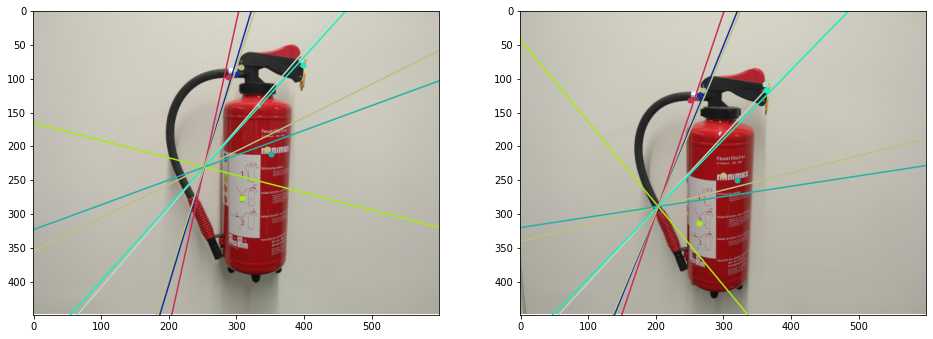

In [79]:
# Observation -> All epipolar lines share a common point of intersection
# Observation -> The point of intersection differs greatly though
# Observation -> Some points are far from their respective epipolar lines as well.
visualize_epipolar_lines(view1, view2, keypoints1[:8], keypoints2[:8], F)


Also, compute the algebraic error, i.e. how well is the epipolar contraint $x_0^TFx_1=0$ met.
Furthermore, calculate the geometric error, i.e. are the points far away from the epipolar lines.
What do the algebraic and geometric error values show you?

In [80]:
def algebraic_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        error = np.abs(kp1[None,...] @ F @ kp2[None,...].T)
        errors.append(error.item())
    return errors

@jit
def geometric_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        x1F = kp1[None,...] @ F
        Fx2 = F @ kp2[None,...].T
        x1Fx2 = x1F @ kp2[None,...].T
        
        part1 = 1/(x1F.flatten()[0] ** 2 + x1F.flatten()[1] ** 2)
        part2 = 1/(Fx2.flatten()[0] ** 2 + Fx2.flatten()[1] ** 2)
        
        error = np.sqrt(x1Fx2 ** 2 * (part1 + part2))
        errors.append(error.item())
    return errors

In [81]:
alg_error = np.mean(algebraic_error(keypoints1, keypoints2, F))
geo_error = np.mean(geometric_error(keypoints1, keypoints2, F))


# Observation: Algebraic error is quite low
# Observation: Geometric error is too high, however
print(f'Mean Algebraic Error: {alg_error}')
print(f'Mean Geometric Error: {geo_error}')

/tmp/ipykernel_18087/2862825782.py:8: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "geometric_error" failed type inference due to: No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 1d, A), Tuple(none, ...))
 
There are 22 candidate implementations:
      - Of which 20 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(array(float64, 1d, A), Tuple(none, ...))':
       No match.
      - Of which 2 did not match due to:
      Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 162.
        With argument(s): '(array(float64, 1d, A), Tuple(none, ...))':
       Rejected as the implementation raised a specific error:
         TypeError: unsupported array index type none in Tuple(none, ...)
  raised from /home/nase/Documents/Uni/Heidelberg/Sem3/ComputerVision/3dcv-student

Mean Algebraic Error: 0.007523580935138667
Mean Geometric Error: 22.604040476925217


### 4.2 Robust estimation using RANSAC
As some of the point matches suffer from noise or are even incorrect. The risk of obtaining an incorrect fundamental matrix by relying just on eight points is high. Hence, we are looking for a more robust version of estimating $F$. To do this, the RANSAC algorithm was introduced in the lecture. Your final task is to complete the implementation for fundamental matrix estimation by using RANSAC. You can compare the errors and epipolar lines of a robustly estimated $F$ with the one from the previous task.

In [91]:
@jit
def find_fundamental_ransac(keypoints1, keypoints2, num_samples=8, threshold=0.01, iterations=1000, min_inliers=30):
    """
    Optimizes fundamental matrix parameters using RANSAC algorithm
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :param num_samples: the number of samples to draw in each iteration
    :param threshold: determines the error value at which we decide for inlier or outlier
    :iterations: maximum number of iterations
    :returns: fundamental matrix and a binary mask indicating the inlier points in keypoints1 and keypoints2
    
    """
    
    min_error   = np.inf
    F_ret       = None
    inliers_ret = None

    for i in range(iterations):

        indices = np.random.choice(keypoints1.shape[0], num_samples, replace=False)
        selected_k1 = keypoints1[indices]
        selected_k2 = keypoints2[indices]

        F = find_fundamental_svd(selected_k1, selected_k2)
        
        errors = np.array(geometric_error(keypoints1, keypoints2, F))
        
        inliers = errors < threshold
        errors = errors[inliers]
        if errors.size > min_inliers:

            mean_error = np.mean(errors)

            if mean_error < min_error:
                min_error   = mean_error
                F_ret       = F
                inliers_ret = inliers

    # print(inliers_ret)
    # print()

    return F_ret, inliers_ret 

In [176]:
F, inliers = find_fundamental_ransac(keypoints1, keypoints2, iterations=100000, threshold=4, min_inliers=30)
print(F)

[[ 1.58470095e-07 -3.54564413e-06  7.74865565e-04]
 [ 3.57591898e-06  3.82844876e-08 -9.49689450e-04]
 [-7.50089929e-04  1.05852737e-03 -4.64198741e-02]]


Now visualize again the epipolar lines and compute the errors. What has changed?

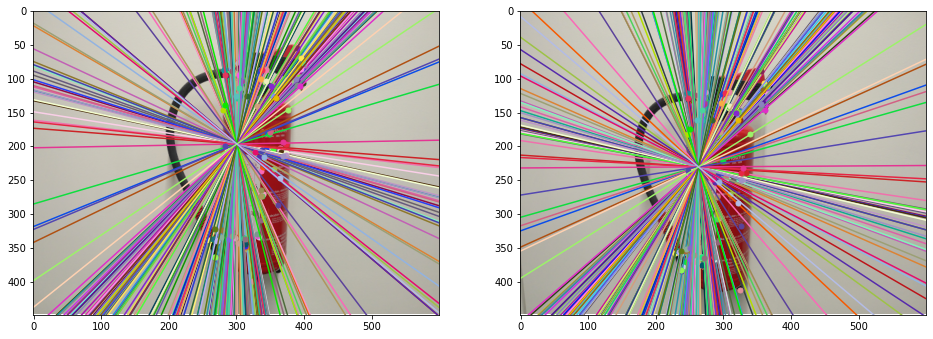

Mean Algebraic Error: 0.0011272243095665543
Mean Geometric Error: 4.70363749713889


In [177]:
visualize_epipolar_lines(view1, view2, keypoints1, keypoints2, F)
alg_error = np.mean(algebraic_error(keypoints1, keypoints2, F))
geo_error = np.mean(geometric_error(keypoints1, keypoints2, F))

# Observation: Algebraic error is quite low
# Observation: Geometric error is too high, however
print(f'Mean Algebraic Error: {alg_error}')
print(f'Mean Geometric Error: {geo_error}')

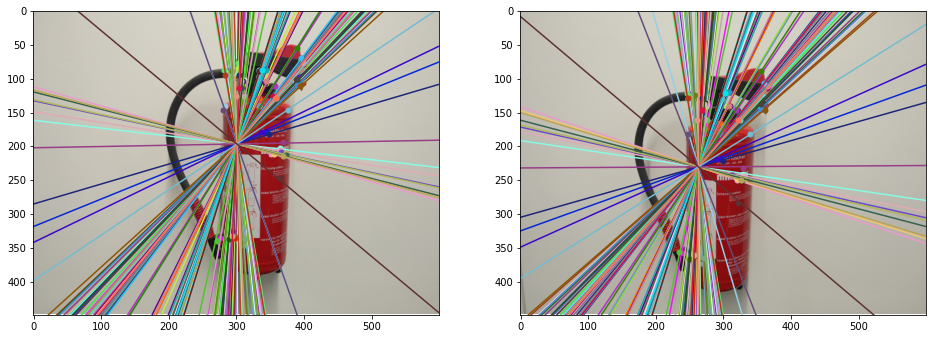

Mean Algebraic Error: 0.000458839958048837
Mean Geometric Error: 1.662915837625336


In [178]:
kps1 = keypoints1[inliers]
kps2 = keypoints2[inliers]
visualize_epipolar_lines(view1, view2, kps1, kps2, F)
alg_error = np.mean(algebraic_error(kps1, kps2, F))
geo_error = np.mean(geometric_error(kps1, kps2, F))

# Observation: Algebraic error is quite low
# Observation: Geometric error is too high, however
print(f'Mean Algebraic Error: {alg_error}')
print(f'Mean Geometric Error: {geo_error}')